In [13]:
from tqdm.notebook import tqdm
from pathlib import Path
import numpy as np
import pandas as pd
import random
import math
import matplotlib.pyplot as plt
from scipy.optimize import least_squares, minimize, basinhopping, differential_evolution
from pyswarm import pso

# PART 1

In [2]:
seed = 1001
eps = 0.001

def generate_data(seed):
    random.seed(seed)
    f = lambda x: 1 / ((x - 2) * (x - 1))
    xs = [0.003 * i for i in range(1001)]
    ys = [min(100, max(- 100, f(x))) + random.random() for x in xs]
    return xs, ys

xs, ys = generate_data(seed)

In [3]:
ra = lambda x, a, b, c, d: (a * x + b) / (x ** 2 + c * x + d)

ra_score = lambda c: sum([(y - ra(x, *c)) ** 2 for x, y in zip(xs, ys)])

In [4]:
def Nelder_Mead(f_score, eps=0.001, seed=None):
    random.seed(seed)
    coeffs = np.array([random.random() for _ in range(4)])
    res = minimize(f_score, x0=coeffs, method='Nelder-Mead')#, options={'xatol':eps, 'fatol':eps})
    return res.nfev, res.nit, res.fun, res.x

def Levenberg_Marquardt_algorithm(f_base, eps=0.001, seed=None):
    seed=1
    random.seed(seed)
    coeffs = np.array([random.random() for _ in range(4)])
    res = least_squares(lambda c: [(f_base(x, *c) - y) ** 2 for x, y in zip(xs, ys)], x0=coeffs, method='lm')# xtol=eps, ftol=eps)
    return res.nfev, res.nfev // 2, sum((f_base(x, *res.x) - y) ** 2 for x, y in zip(xs, ys)), res.x

def simulated_annealing(f_score, eps=0.001, seed=None):
    random.seed(seed)
    coeffs = np.array([random.random() for _ in range(4)])
    res = basinhopping(f_score, x0=coeffs, niter=1000, seed=seed)
    return res.nfev, res.nit, res.fun, res.x

def differential_evolution_method(f_score, eps=0.001, seed=None):
    res = differential_evolution(f_score, [(- 3, 3) for _ in range(4)], maxiter=1000, seed=seed)#, atol=eps, tol=eps)
    return res.nfev, res.nit, res.fun, res.x

def particle_swarm(f_score, eps=0.001, seed=None):
    xopt, fopt = pso(f_score, lb=[- 3] * 4, ub=[3] * 4, maxiter=1000)
    return 100 * 1000, 1000, fopt, xopt

In [5]:
%%time

results = [[] for _ in range(4)]  # f_num, iter_num, f_min, coeffs
methods = (Nelder_Mead, Levenberg_Marquardt_algorithm, simulated_annealing, differential_evolution_method, particle_swarm)
args = ((ra_score,), (ra,), (ra_score,), (ra_score,), (ra_score,))

for a,m in zip(args, methods):
    res = m(*a, eps=eps, seed=seed)
    for i in range(4):
        results[i].append(res[i])

Stopping search: Swarm best position change less than 1e-08
Wall time: 27min 56s


In [6]:
pd.DataFrame({'Method': [methods[i].__name__ for i in range(len(methods))], 'Number of function calls': results[0],\
             'Number of iterations': results[1], 'Found F minimum': results[2]})#.to_csv('lab4_results.csv', index=False)

,Method,Number of function calls,Number of iterations,Found F minimum
0,Nelder_Mead,579,338,176002.416844
1,Levenberg_Marquardt_algorithm,234,117,136034.484247
2,simulated_annealing,632725,1000,135241.456615
3,differential_evolution_method,1075,7,151903.775735
4,particle_swarm,100000,1000,184695.844770


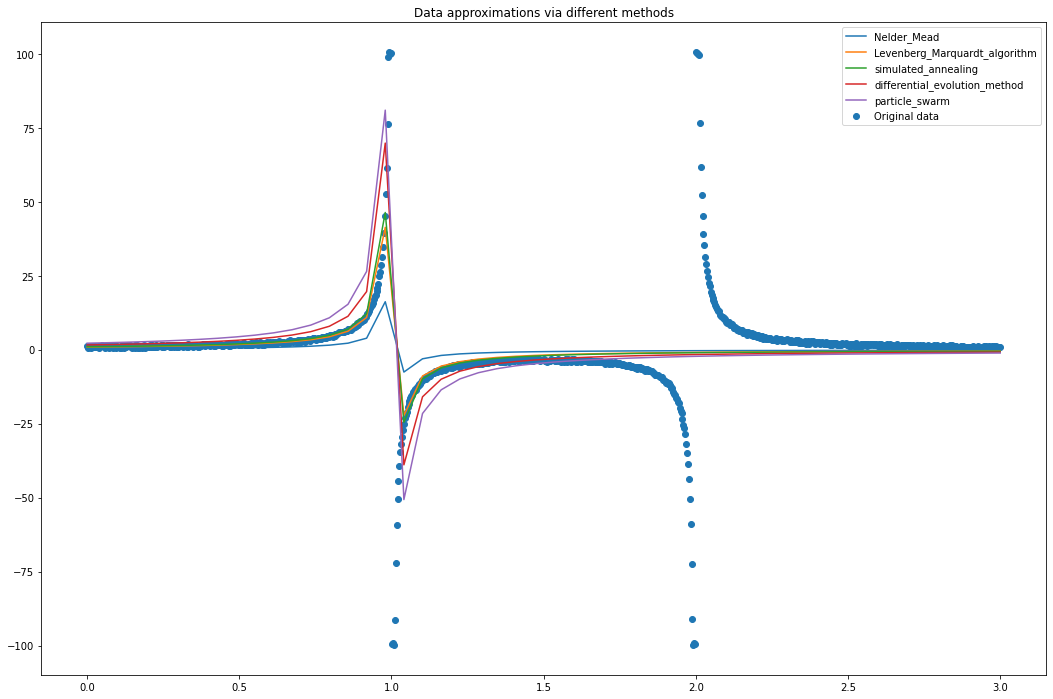

In [7]:
x_domain = np.linspace(0, 3)
plt.rcParams["figure.figsize"] = 18, 12
plt.scatter(x=xs, y=ys)
plt.title('Data approximations via different methods')
for i in range(len(methods)):
    plt.plot(x_domain, [ra(x, *results[3][i]) for x in x_domain])
plt.legend([methods[i].__name__ for i in range(len(methods))] + ['Original data'])

# PART 2

In [12]:
def get_dist_matrix(path):
    with open(path, 'r') as f:
        lines = f.readlines()
    return np.array([list(map(int, line.strip().split())) for line in lines])

dm = get_dist_matrix(Path('lau15_dist.txt'))
dm

array([[ 0, 29, 82, 46, 68, 52, 72, 42, 51, 55, 29, 74, 23, 72, 46],
       [29,  0, 55, 46, 42, 43, 43, 23, 23, 31, 41, 51, 11, 52, 21],
       [82, 55,  0, 68, 46, 55, 23, 43, 41, 29, 79, 21, 64, 31, 51],
       [46, 46, 68,  0, 82, 15, 72, 31, 62, 42, 21, 51, 51, 43, 64],
       [68, 42, 46, 82,  0, 74, 23, 52, 21, 46, 82, 58, 46, 65, 23],
       [52, 43, 55, 15, 74,  0, 61, 23, 55, 31, 33, 37, 51, 29, 59],
       [72, 43, 23, 72, 23, 61,  0, 42, 23, 31, 77, 37, 51, 46, 33],
       [42, 23, 43, 31, 52, 23, 42,  0, 33, 15, 37, 33, 33, 31, 37],
       [51, 23, 41, 62, 21, 55, 23, 33,  0, 29, 62, 46, 29, 51, 11],
       [55, 31, 29, 42, 46, 31, 31, 15, 29,  0, 51, 21, 41, 23, 37],
       [29, 41, 79, 21, 82, 33, 77, 37, 62, 51,  0, 65, 42, 59, 61],
       [74, 51, 21, 51, 58, 37, 37, 33, 46, 21, 65,  0, 61, 11, 55],
       [23, 11, 64, 51, 46, 51, 51, 33, 29, 41, 42, 61,  0, 62, 23],
       [72, 52, 31, 43, 65, 29, 46, 31, 51, 23, 59, 11, 62,  0, 59],
       [46, 21, 51, 64, 23, 59, 33

In [30]:
def get_metric(order):
    res = 0
    for i in range(len(order) - 1):
        res += dm[order[i]][order[i + 1]]
    res += dm[order[- 1]][order[0]]
    return res

def simulated_annealing(dm, seed=None):
    random.seed(seed)
    n = len(dm)
    
    def inverse(order, i, j):
        return order[:i] + list(reversed(order[i: j + 1])) + order[j + 1:]
    
    def insert(order, i, j):
        return order[:i] + order[j: j + 1] + order[i: j] + order[j + 1:]
    
    def swap(order, i, j):
        return order[:i] + order[j: j + 1] + order[i + 1: j] + order[i: i + 1] + order[j + 1:]
        
    init_order = cur_order = list(np.random.permutation(n))
    init_metric = cur_metric = get_metric(cur_order)
    t = 100
    pbar = tqdm()
    while t > 0.1:
        i, j = random.sample(range(n), 2)
        if j < i: i, j = j, i
        orders = []
        metrics = []
        for op in (inverse, insert, swap):
            orders.append(op(cur_order, i, j))
            metrics.append(get_metric(orders[- 1]))
        order = orders[np.argmin(metrics)]
        metric = min(metrics)
        if metric < cur_metric or random.random() < math.exp((cur_metric - metric) / t):
            cur_metric = metric
            cur_order = order
        
        t *= 0.99
        pbar.update()
    pbar.close()
    return init_order, init_metric, cur_order, cur_metric

In [35]:
init_order, init_metric, last_order, last_metric = simulated_annealing(dm, seed=seed)

0it [00:00, ?it/s]

In [36]:
with open('lau15_tsp.txt', 'r') as f:
    best_order = [int(line.strip()) - 1 for line in f.readlines()]
best_metric = get_metric(best_order)
best_order, best_metric

([0, 12, 1, 14, 8, 4, 6, 2, 11, 13, 9, 7, 5, 3, 10], 291)

In [37]:
assert last_metric == best_metric

In [40]:
with open('lau15_xy.txt', 'r') as f:
    coords = [list(map(float, line.strip().split())) for line in f.readlines()]
xs = [x[0] for x in coords]
ys = [x[1] for x in coords]

In [49]:
def draw_graph(order):
    plt.scatter(x=xs, y=ys)
    for i in range(len(order) - 1):
        plt.plot([xs[order[i]], xs[order[i + 1]]], [ys[order[i]], ys[order[i + 1]]], color='red')
    plt.plot([xs[order[- 1]], xs[order[0]]], [ys[order[- 1]], ys[order[0]]], color='red')

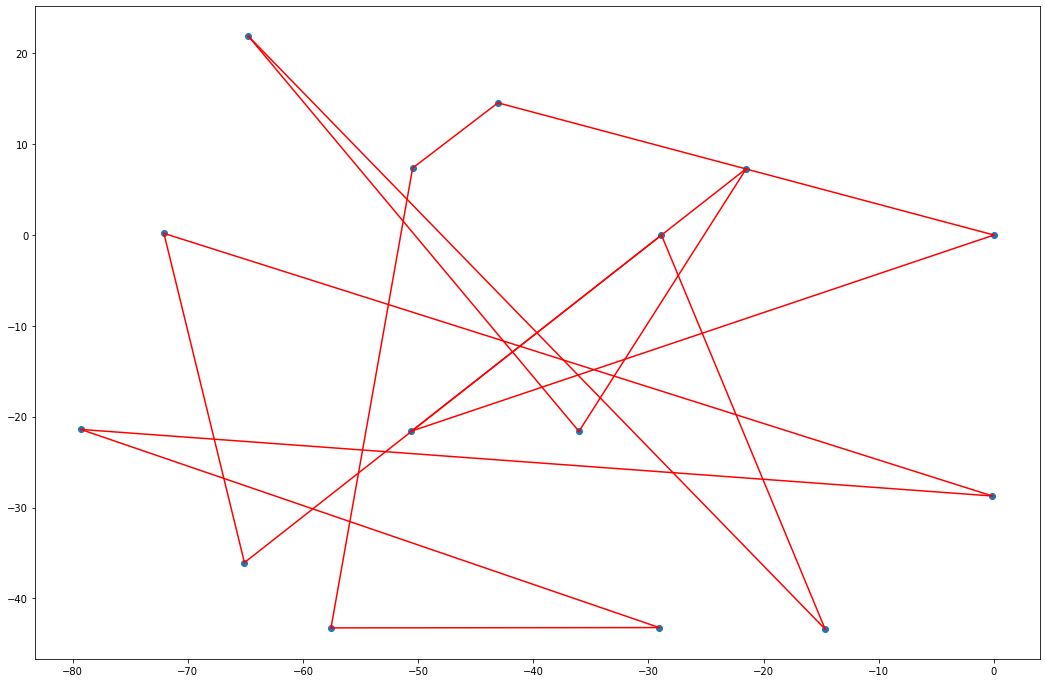

In [51]:
draw_graph(init_order)

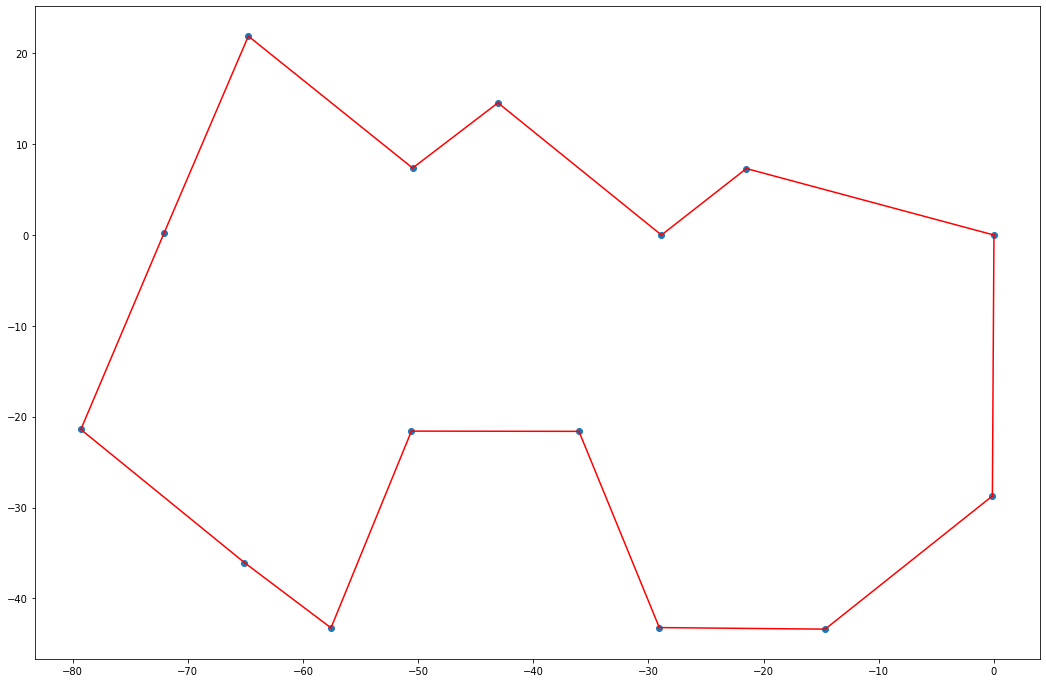

In [52]:
draw_graph(last_order)